# EDA — Movie Recommendation System

**Goal:** Understand the data structure and key patterns (ratings distribution, user activity, movie popularity, sparsity) using **locally saved Parquet files** to avoid repeated BigQuery queries.

**Inputs (from `data/`):**
- `interactions.parquet` — filtered interactions (`userId`, `movieId`, `rating`, `timestamp`)
- `movie_stats.parquet` — per-movie stats (`movieId`, `n_ratings`, `avg_rating`, `std_rating`)
- `user_stats.parquet` — per-user stats (`userId`, `n_ratings`, `avg_rating`, `first_ts`, `last_ts`)

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="mako")
plt.rcParams["figure.figsize"] = (10, 5)


In [42]:
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd().parent   
DATA_DIR = PROJECT_ROOT / "data"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)

PROJECT_ROOT: /home/jupyter/IslemFatma_Yassine/Personalized_Movie_Recommendation_System
DATA_DIR: /home/jupyter/IslemFatma_Yassine/Personalized_Movie_Recommendation_System/data


In [43]:
interactions_path = DATA_DIR / "interactions.parquet"
movie_stats_path = DATA_DIR / "movie_stats.parquet"
user_stats_path = DATA_DIR / "user_stats.parquet"

assert interactions_path.exists(), interactions_path
assert movie_stats_path.exists(), movie_stats_path
assert user_stats_path.exists(), user_stats_path

interactions = pd.read_parquet(interactions_path)
movie_stats = pd.read_parquet(movie_stats_path)
user_stats = pd.read_parquet(user_stats_path)

print("Loaded:")
print(" - interactions:", interactions.shape)
print(" - movie_stats:", movie_stats.shape)
print(" - user_stats:", user_stats.shape)


Loaded:
 - interactions: (70513, 4)
 - movie_stats: (1322, 4)
 - user_stats: (668, 5)


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="mako")
plt.rcParams["figure.figsize"] = (10, 5)

## Dataset overview
### Basic Statistics

In [45]:
num_users = user_stats.shape[0]
num_movies = movie_stats.shape[0]
num_ratings = interactions.shape[0]

total_possible = num_users * num_movies
sparsity = 1 - (num_ratings / total_possible) if total_possible else np.nan

overview = pd.DataFrame([{
    "num_users_filtered": num_users,
    "num_movies_filtered": num_movies,
    "num_ratings_filtered": num_ratings,
    "sparsity_filtered": sparsity
}])
overview

/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:406: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:406: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,num_users_filtered,num_movies_filtered,num_ratings_filtered,sparsity_filtered
0,668,1322,70513,0.920153


/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:406: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,n_ratings
0.50,38.00
0.75,63.75
0.90,105.00
0.95,140.95
0.99,227.16


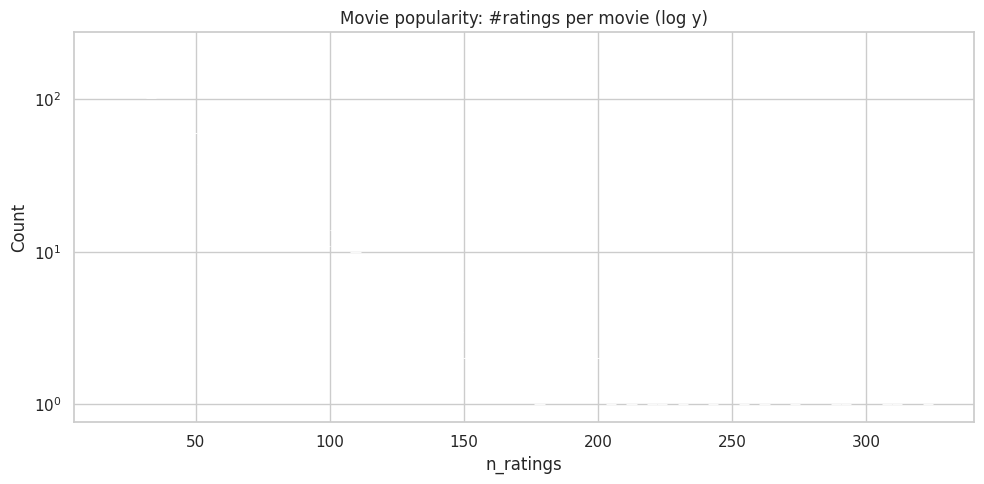

% movies with <5 ratings : 0.0
% movies with <10 ratings: 0.0
Share of ratings by top 1% movies : 0.0531
Share of ratings by top 10% movies: 0.2952


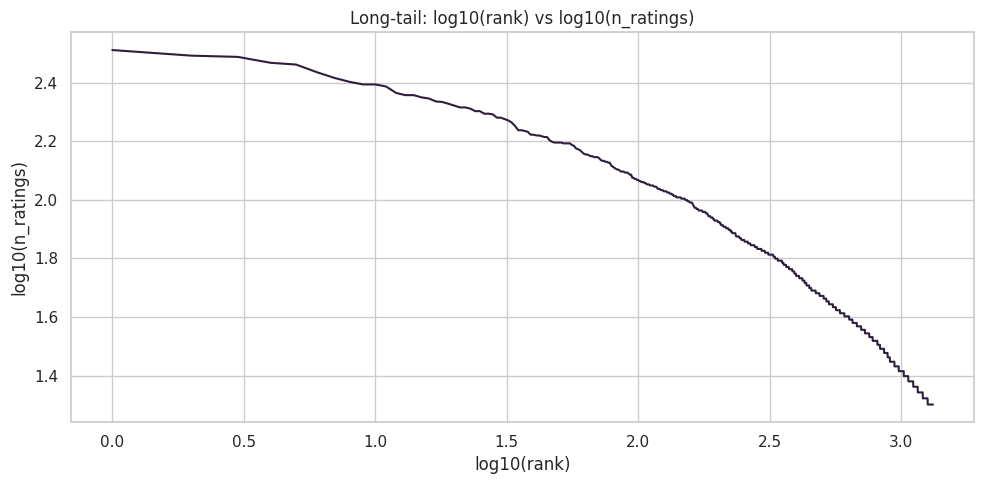

In [46]:
movie_stats2 = (
    interactions_clean.groupby("movieId")
    .agg(
        n_ratings=("rating", "size"),
        avg_rating=("rating", "mean"),
        std_rating=("rating", "std"),
    )
    .reset_index()
)

display(movie_stats2["n_ratings"].quantile([0.5, 0.75, 0.9, 0.95, 0.99]).to_frame("n_ratings"))

sns.histplot(movie_stats2["n_ratings"], bins=80, log_scale=(False, True))
plt.title("Movie popularity: #ratings per movie (log y)")
plt.xlabel("n_ratings")
plt.tight_layout()
plt.show()

print("% movies with <5 ratings :", round((movie_stats2["n_ratings"] < 5).mean(), 4))
print("% movies with <10 ratings:", round((movie_stats2["n_ratings"] < 10).mean(), 4))

# Long-tail share
movie_sorted = movie_stats2.sort_values("n_ratings", ascending=False).reset_index(drop=True)
movie_sorted["cum_share"] = movie_sorted["n_ratings"].cumsum() / movie_sorted["n_ratings"].sum()

top_1pct = max(1, int(np.ceil(0.01 * len(movie_sorted))))
top_10pct = max(1, int(np.ceil(0.10 * len(movie_sorted))))

print("Share of ratings by top 1% movies :", round(float(movie_sorted.loc[top_1pct-1, "cum_share"]), 4))
print("Share of ratings by top 10% movies:", round(float(movie_sorted.loc[top_10pct-1, "cum_share"]), 4))

counts = movie_sorted["n_ratings"].values
plt.plot(np.log10(np.arange(1, len(counts)+1)), np.log10(counts))
plt.title("Long-tail: log10(rank) vs log10(n_ratings)")
plt.xlabel("log10(rank)"); plt.ylabel("log10(n_ratings)")
plt.tight_layout()
plt.show()


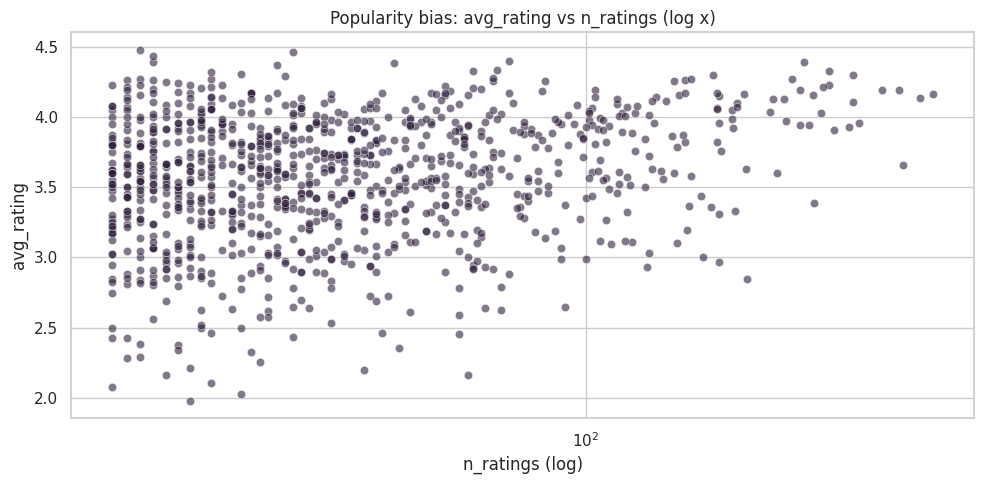

In [47]:
# ---------- Popularity bias ----------
sample_n = min(len(movie_stats2), 1000)
sns.scatterplot(
    data=movie_stats2.sample(sample_n, random_state=42),
    x="n_ratings", y="avg_rating", alpha=0.6
)
plt.xscale("log")
plt.title("Popularity bias: avg_rating vs n_ratings (log x)")
plt.xlabel("n_ratings (log)"); plt.ylabel("avg_rating")
plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:406: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,n_ratings
0.50,56.00
0.75,117.00
0.90,237.30
0.95,370.30
0.99,651.33


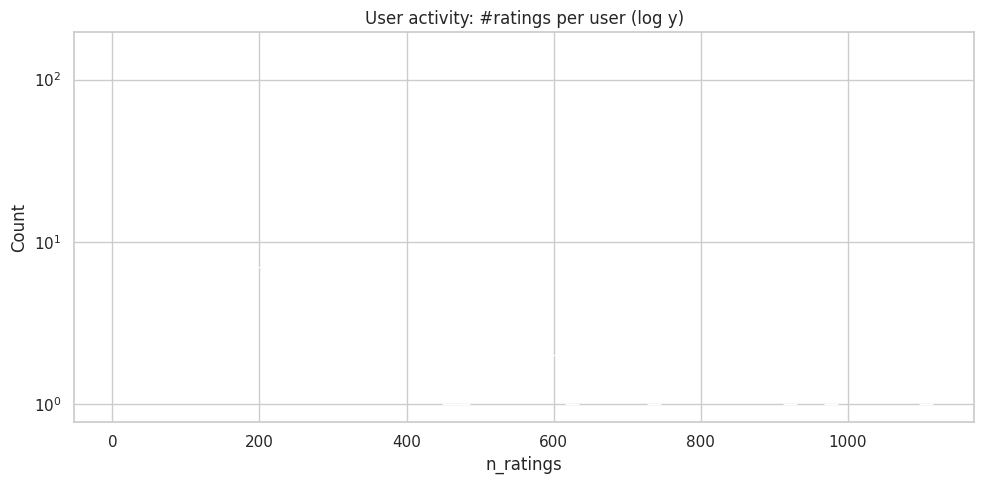

% users with <5 ratings : 0.0015
% users with <10 ratings: 0.009
% users with >=5 ratings (split-ready): 0.9985


In [48]:
## User Activity Analysis
# ---------- User stats (recomputed) ----------
user_stats2 = (
    interactions_clean.groupby("userId")
    .agg(
        n_ratings=("rating", "size"),
        avg_rating=("rating", "mean"),
        std_rating=("rating", "std"),
        first_ts=("timestamp", "min"),
        last_ts=("timestamp", "max"),
    )
    .reset_index()
)

display(user_stats2["n_ratings"].quantile([0.5, 0.75, 0.9, 0.95, 0.99]).to_frame("n_ratings"))

sns.histplot(user_stats2["n_ratings"], bins=60, log_scale=(False, True))
plt.title("User activity: #ratings per user (log y)")
plt.xlabel("n_ratings")
plt.tight_layout()
plt.show()

print("% users with <5 ratings :", round((user_stats2["n_ratings"] < 5).mean(), 4))
print("% users with <10 ratings:", round((user_stats2["n_ratings"] < 10).mean(), 4))
print("% users with >=5 ratings (split-ready):", round((user_stats2["n_ratings"] >= 5).mean(), 4))

In [49]:
## Movie Popularity Analysis

merged: (70513, 6) | g: (200637, 7)


/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:406: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:406: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,userId,movieId,rating,timestamp,genres,title,genre
0,312,160,2.0,828564954,Action|Adventure|Mystery|Sci-Fi,Congo (1995),Action
0,312,160,2.0,828564954,Action|Adventure|Mystery|Sci-Fi,Congo (1995),Adventure
0,312,160,2.0,828564954,Action|Adventure|Mystery|Sci-Fi,Congo (1995),Mystery
0,312,160,2.0,828564954,Action|Adventure|Mystery|Sci-Fi,Congo (1995),Sci-Fi
1,312,110,5.0,828564954,Action|Drama|War,Braveheart (1995),Action


/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:406: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:406: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,genre,n_ratings
0,Drama,29806
1,Comedy,25510
2,Action,24549
3,Thriller,21279
4,Adventure,18753
5,Sci-Fi,13538
6,Crime,13384
7,Romance,12788
8,Fantasy,8296
9,Mystery,6003


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


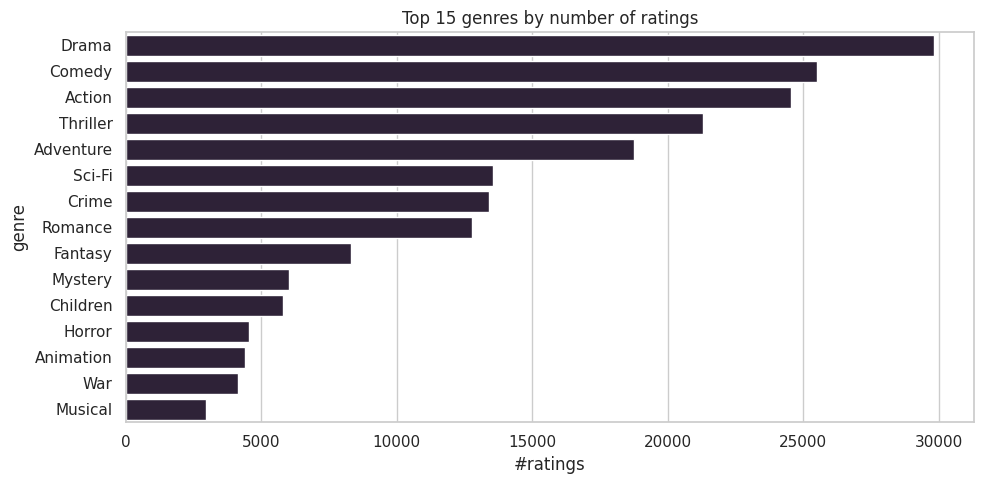

/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:406: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,genre,n_ratings,avg_rating,std_rating
9,Film-Noir,767,4.082138,0.847994
17,War,4127,3.898958,0.943491
6,Documentary,210,3.800000,0.978477
7,Drama,29806,3.789187,0.954063
13,Mystery,6003,3.782442,0.948558
5,Crime,13384,3.776375,0.966919
11,IMAX,2248,3.749333,0.967542
2,Animation,4378,3.708885,0.946323
12,Musical,2955,3.670897,0.996642
14,Romance,12788,3.664842,0.996024


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


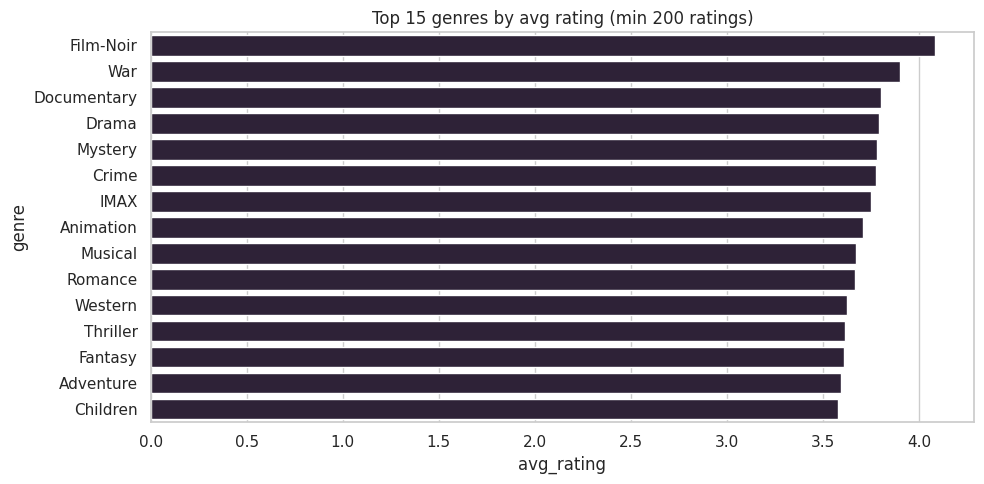

/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:406: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,count,mean,std,min,25%,50%,75%,max
n_distinct_genres,668.0,15.977545,2.307885,5.0,15.0,16.0,18.0,19.0


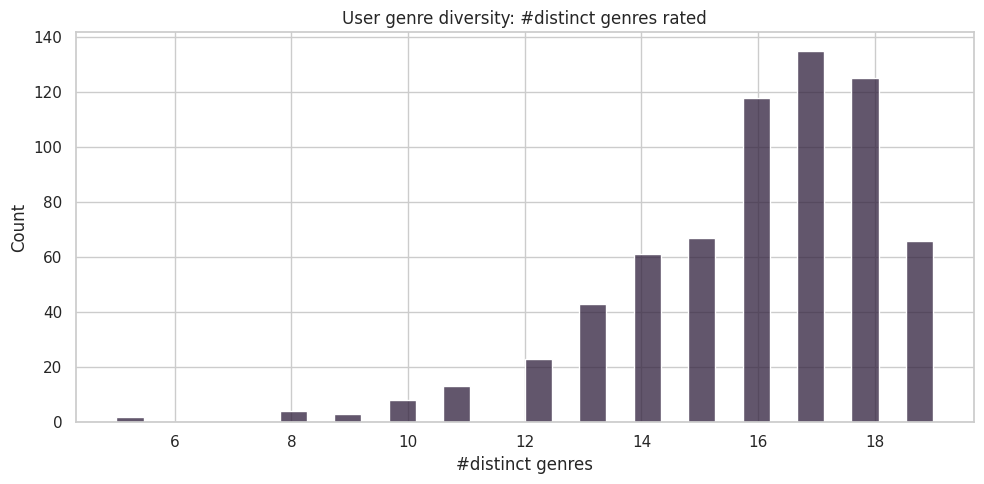

In [50]:
# =========================
# Genre Analysis
# =========================

from pathlib import Path

df = interactions.copy()
df = df.sort_values("timestamp").drop_duplicates(["userId", "movieId"], keep="last")

# 1) Load movies (local first, fallback BigQuery)
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
movies_path = DATA_DIR / "movies.parquet"

if movies_path.exists():
    movies = pd.read_parquet(movies_path)
else:
    from google.cloud import bigquery
    client = bigquery.Client()
    movies = client.query("""
        SELECT movieId, title, genres
        FROM `master-ai-cloud.MoviePlatform.movies`
    """).to_dataframe()

assert "movieId" in movies.columns
assert "genres" in movies.columns

movies = movies.copy()
movies["movieId"] = pd.to_numeric(movies["movieId"], errors="coerce")
movies["genres"] = movies["genres"].fillna("(no genres listed)").astype(str)

df = df.copy()
df["movieId"] = pd.to_numeric(df["movieId"], errors="coerce")

# 2) Merge + explode genres  ==> defines g (fixes your NameError)
keep_cols = ["movieId", "genres"] + (["title"] if "title" in movies.columns else [])
merged = df.merge(movies[keep_cols], on="movieId", how="left")
merged["genres"] = merged["genres"].fillna("(no genres listed)").astype(str)

g = merged.assign(genre=merged["genres"].str.split("|")).explode("genre")
g["genre"] = g["genre"].fillna("(no genres listed)").astype(str)

print("merged:", merged.shape, "| g:", g.shape)
display(g.head())

# 3) Top genres by number of ratings
genre_counts = g["genre"].value_counts().rename_axis("genre").reset_index(name="n_ratings")
display(genre_counts.head(20))

sns.barplot(data=genre_counts.head(15), x="n_ratings", y="genre")
plt.title("Top 15 genres by number of ratings")
plt.xlabel("#ratings"); plt.ylabel("genre")
plt.tight_layout()
plt.show()

# 4) Avg rating by genre (min support)
min_n = 200
genre_stats = (g.groupby("genre")
                 .agg(n_ratings=("rating", "size"),
                      avg_rating=("rating", "mean"),
                      std_rating=("rating", "std"))
                 .reset_index())

genre_stats_big = genre_stats[genre_stats["n_ratings"] >= min_n].sort_values("avg_rating", ascending=False)
display(genre_stats_big.head(20))

if len(genre_stats_big) > 0:
    sns.barplot(data=genre_stats_big.head(15), x="avg_rating", y="genre")
    plt.title(f"Top 15 genres by avg rating (min {min_n} ratings)")
    plt.xlabel("avg_rating"); plt.ylabel("genre")
    plt.tight_layout()
    plt.show()
else:
    print(f"No genre has >= {min_n} ratings. Reduce min_n and rerun.")

# 5) User genre diversity
user_genre_n = g.groupby("userId")["genre"].nunique().reset_index(name="n_distinct_genres")
display(user_genre_n["n_distinct_genres"].describe().to_frame().T)

sns.histplot(user_genre_n["n_distinct_genres"], bins=30)
plt.title("User genre diversity: #distinct genres rated")
plt.xlabel("#distinct genres")
plt.tight_layout()
plt.show()


Time range: 1996-04-03 20:55:54 -> 2016-01-10 05:48:39


/var/tmp/ipykernel_40732/2688606736.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_month.plot()
/var/tmp/ipykernel_40732/2688606736.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_month.plot()
/var/tmp/ipykernel_40732/2688606736.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_month.plot()


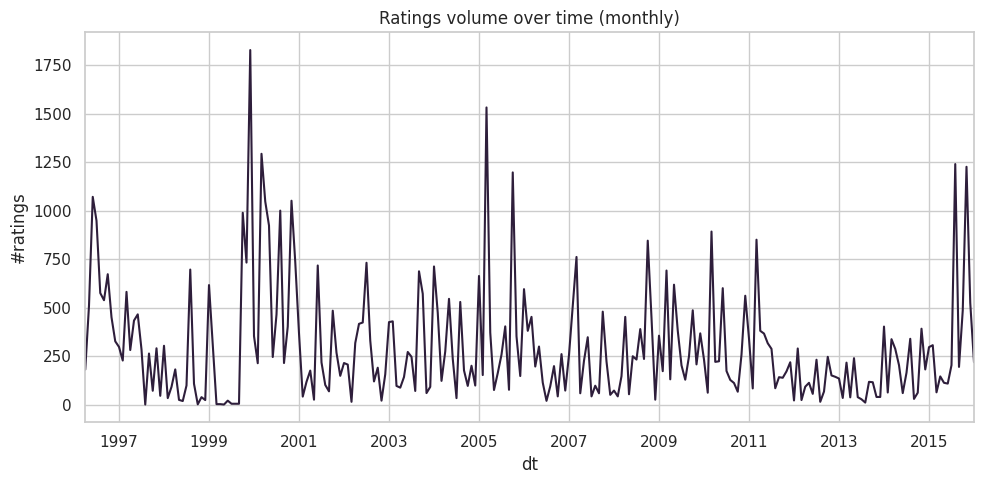

/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:406: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,count,mean,std,min,25%,50%,75%,max
recency_days,70513.0,3929.883071,2099.397112,0.0,2267.0,4016.0,5726.0,7220.0


In [51]:
## Temporal Analysis
interactions_t = interactions_clean.copy()
interactions_t["dt"] = pd.to_datetime(interactions_t["timestamp"], unit="s", errors="coerce")

min_dt, max_dt = interactions_t["dt"].min(), interactions_t["dt"].max()
print("Time range:", min_dt, "->", max_dt)

ts_month = interactions_t.set_index("dt").resample("MS").size()
ts_month.plot()
plt.title("Ratings volume over time (monthly)")
plt.ylabel("#ratings")
plt.tight_layout()
plt.show()

recency_days = (interactions_t["dt"].max() - interactions_t["dt"]).dt.days
display(recency_days.describe().to_frame("recency_days").T)

In [52]:
## Data Quality Check
dq = {
    "null_rate_userId": interactions["userId"].isna().mean(),
    "null_rate_movieId": interactions["movieId"].isna().mean(),
    "null_rate_rating": interactions["rating"].isna().mean(),
    "null_rate_timestamp": interactions["timestamp"].isna().mean(),
    "duplicate_user_movie_rate": interactions.duplicated(["userId", "movieId"]).mean(),
    "rating_min": float(np.nanmin(interactions["rating"].values)),
    "rating_max": float(np.nanmax(interactions["rating"].values)),
}
display(pd.DataFrame([dq]))

# Clean (no saving)
interactions_clean = interactions.dropna(subset=["userId", "movieId", "rating", "timestamp"]).copy()
interactions_clean = (
    interactions_clean.sort_values("timestamp")
    .drop_duplicates(["userId", "movieId"], keep="last")
)

print("Interactions before clean:", interactions.shape)
print("Interactions after clean :", interactions_clean.shape)



/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:406: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:406: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,null_rate_userId,null_rate_movieId,null_rate_rating,null_rate_timestamp,duplicate_user_movie_rate,rating_min,rating_max
0,0.0,0.0,0.0,0.0,0.0,0.5,5.0


Interactions before clean: (70513, 4)
Interactions after clean : (70513, 4)
